In [261]:
import collections

Sample = collections.namedtuple('Sample', ['timestamp', 'gnss_easting', 'gnss_northing', 'odom_drive', 'odom_steer', 'lidar'])

In [260]:
def read_log(file):
  result = []
  for line in file:
    sample = line.split()
    result.append(Sample(
        float(sample[0]), 
        float(sample[1]), 
        float(sample[2]), 
        float(sample[3]), 
        float(sample[4]), 
        list(map(lambda s: float(s), sample[5::]))
        ))
  return result

In [291]:
import math
WHEELBASE_LENGTH = 0.32
Pose = collections.namedtuple('Pose', ['x', 'y', 'theta'])
def parse_odometry(log):
  poses = [Pose(0.0, 0.0, 0.0)]
  prev_samp = log[0]
  for samp in log[1::]:
    # https://thomasfermi.github.io/Algorithms-for-Automated-Driving/Control/BicycleModel.html
    dt = samp.timestamp - prev_samp.timestamp
    poses.append(
      Pose(
        poses[-1].x + (samp.odom_drive * dt * math.cos(poses[-1].theta)), 
        poses[-1].y + (samp.odom_drive * dt * math.sin(poses[-1].theta)), 
        poses[-1].theta + (samp.odom_drive * dt * math.tan(samp.odom_steer) * (1 / WHEELBASE_LENGTH))
        )
      )
    prev_samp = samp
  return poses


In [281]:
Trans = collections.namedtuple('Trans', ['x', 'y'])

def parse_lidar(path, log):
  detections = []
  for (samp, pose) in zip(log, path):
    for (i, radius) in enumerate(samp.lidar):
      if radius == -1:
        continue
      theta = -(pose.theta + (((float(i) / (len(samp.lidar))) * 2 * math.pi)))
      x = math.cos(theta) * radius
      y = math.sin(theta) * radius
      detections.append(
        Trans(
          pose.x + x,
          pose.y + y
        )
    )
  return detections

[Sample(timestamp=0.0, gnss_easting=0.15000000000000002, gnss_northing=0.0, odom_drive=0.75, odom_steer=-0.030976176032274184, lidar=[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.4545454545454546, 1.2121212121212122, 1.2121212121212122, 1.0909090909090908, 1.0909090909090908, 1.0909090909090908, 1.0909090909090908, 1.0909090909090908, 1.2121212121212122, 1.3333333333333335, 1.5757575757575757, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.3333333333333335, 1.2121212121212122, 1.0909090909090908, 1.0909090909090908, 1.0909090909090908, 1.0909090909090908, 1.0909090909090908, 1.0909090909090908, 1.2121212121212122, 1.3333333333333335, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]), Sample(timestamp=0.2, gnss_easting=0.2999841776979973, gnss_northing=-0.0021786326573295257, odom_drive=0.75, odom_steer=0.3125444294458379, lidar=[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1

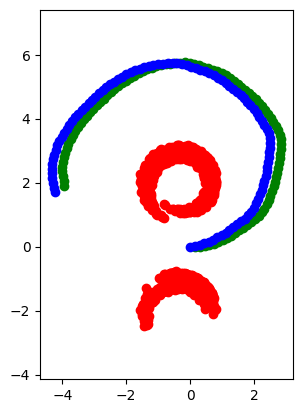

In [300]:
import matplotlib.pyplot as plt
test_log = read_log(open('./test_log.log', 'r'))
print(test_log)
odometry = parse_odometry(test_log)
print(odometry)
detections = parse_lidar(odometry, test_log)
print(detections)

# show odo
fig, ax1 = plt.subplots()
ax1.set_ymargin(0.2)
ax1.scatter(list(map(lambda samp: samp.gnss_easting, test_log)), list(map(lambda samp: samp.gnss_northing, test_log)), color='green')
ax1.scatter(list(map(lambda pose: pose.x, odometry)), list(map(lambda pose: pose.y, odometry)), color='blue')
ax1.scatter(list(map(lambda trans: trans.x, detections)), list(map(lambda trans: trans.y, detections)), color='red')
ax1.set_aspect('equal')
plt.show()